<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./214_ltpy_AC_SAF_GOME-2_L3.ipynb"><< 214 - AC SAF GOME-2 - Level 3</a><span style="float:right;"><a href="./22_ltpy_GOME-2_PMAp_load_browse.ipynb">22 - GOME-2 - PMAp product - Load and browse >></a></span>

# 2.1.5 AC SAF - GOME-2 - Level 3 - Aerosol Absorbing Index (AAI) data

The data of the GOME-2 `Absorbing Aerosol Index (AAI)` are provided by KNMI in the framework of the [EUMETSAT Satellite Application Facility on Atmospheric Composition Monitoring (AC SAF)](https://acsaf.org/index.html).

The Absorbing Aerosol Index (AAI) indicates the presence of elevated absorbing aerosols in the Earth's atmosphere. The aerosol types that are mostly seen in the AAI are desert dust and biomass burning aerosols. 

The web-based service for atmospheric satellite data products [TEMIS](http://www.temis.nl/airpollution/absaai/), maintained by KNMI, provides daily and monthly aggregated Level 3 (gridded) data products for the three satellites Metop-A, -B, and -C.

Find more information on the GOME-2 Level 3 AAI data product processed by KNMI [here](http://www.temis.nl/airpollution/absaai/gome2/GOME2_aai.README).

#### This module has the following outline:
* [1 - Load and browse GOME-2 Level 3 AAI data](#load_browse)
* [2 - Concatenate the data from the three satellites Metop-A, -B and -C](#concat)
* [3 - Retrieve  time coordinate information and assign time coordinates for the time dimension](assign_time_coord)
* [4 - Combine AAI data from the three satellites Metop-A, -B, and -C onto one single grid](#combine)
* [5 - Visualize AAI data with data from the three satellites Metop-A, -B, and C combined on one single grid](#visualize)
* [6 - Animate daily GOME-2 Level 3 Absorbed Aerosol Index (AAI) data between 28 December 2019 and 20 January 2020](#animate)



#### Load required libraries

In [1]:
import os
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

from IPython.display import HTML
# Python libraries for visualisation
from matplotlib import pyplot as plt
from matplotlib import animation


import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
from ipynb.fs.full.ltpy_functions import visualize_s5p_pcolormesh

<hr>

## <a id='load_browse'></a>Load and browse GOME-2 Level 3 AAI data

The GOME-3 Level 3 AAI data files can be downloaded from the TEMIS website in `NetCDF` data format. TEMIS offers the data of all three satellites Metop-A, -B and -C, which, combined, provide daily measurements for the entire globe.

The following example uses daily gridded AAI data for the three satellites Metop-A, -B, and -C for 24 consecutive days between `28 December 2019 and 20 January 2020`. The example shows the dispersion of aerosols during the Australian fires in January 2020.

The daily gridded data is available for each satellite. Thus, a first step is to inspect one file to get a better understanding of the general data structure. Followed by loading the data files for the entire time period into one xarray `DataArray` and to repeat this for each of the three satellites Metop-A, -B and -C.

### Inspect the structure of one daily gridded AAI data file

The data is in the folder `/eodata/gome2/level3/aai/`. Since the data is distributed in the `NetCDF` format, you can use the xarray function `open_dataset()` to load one single file to better understand the data structure.

In [3]:
file = './eodata/gome2/level3/aai/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20191228-fv1.7.nc'
aai_gome2a = xr.open_dataset(file)
aai_gome2a

<xarray.Dataset>
Dimensions:                  (latitude: 180, longitude: 360)
Coordinates:
  * longitude                (longitude) float32 -179.5 -178.5 ... 178.5 179.5
  * latitude                 (latitude) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables:
    absorbing_aerosol_index  (latitude, longitude) float32 ...
    number_of_observations   (latitude, longitude) int16 ...
    solar_zenith_angle       (latitude, longitude) float32 ...
Attributes:
    Conventions:                CF-1.6
    title:                      ESA CCI absorbing aerosol index level 3 product
    description:                Multi-Sensor AAI field for 28-12-2019
    institution:                Royal Netherlands Meteorological Institute (K...
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-aerosol-cci.org
    product_version:            1.7
    cdm_data_type:              Grid
    date_created:               20191229T080243Z

The output of the xarray `Dataset` above show that one file contains the data of three variables: <br>
* `absorbing_aerosol_index`,
* `number_of_observations`, and
* `solar_zenith_angle`. 

The variable of interest is `absorbing aerosol_index`. By adding the variable of interest into square brackets `[]`, you can select the variable's `DataArray`. You can see that the daily gridded data are on a 1 deg x 1 deg data grid, with 180 latitude values and 360 longitude values.

In [4]:
aai = aai_gome2a['absorbing_aerosol_index']
aai


<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

### Load a time-series of daily GOME-2 Level 3 AAI data into one xarray `Dataset`

The xarray `open_mfdataset()` function allows the openening of multiple files at once. You have to specify the dimension the files shall be concatenated by. It can be an existing dimension within the data file or a new dimension, which is newly specified.

Let's open the daily gridded AAI data from Metop-A for the 24 days from 28 December 2019 to 20 January 2020 and we specify `time` as a new dimension the data files shall be concatenated by.

After you loaded the multiple files in a `Dataset` with the function `open_mfdataset()`, you have to select again `absorbing_aerosol_index` as the variable of interest.

The resulting `DataArray` has three dimensions (`time`, `latitude` and `longitude`).


In [5]:
ds_a = xr.open_mfdataset('./eodata/gome2/level3/aai/ESACCI-AEROSOL-L3-AAI-GOME2A*.nc', concat_dim='time', combine='nested')
aai_a=ds_a['absorbing_aerosol_index']
aai_a

<xarray.DataArray 'absorbing_aerosol_index' (time: 24, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(24, 180, 360), dtype=float32, chunksize=(1, 180, 360)>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

The same process has to be repeated for the daily gridded AAI data from the satellites Metop-B and Metop-C respectively.
Below, we load the data from the Metop-B satellite.

In [6]:
ds_b = xr.open_mfdataset('./eodata/gome2/level3/aai/ESACCI-AEROSOL-L3-AAI-GOME2B*.nc', concat_dim='time', combine='nested')
aai_b =ds_b['absorbing_aerosol_index']
aai_b

<xarray.DataArray 'absorbing_aerosol_index' (time: 24, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(24, 180, 360), dtype=float32, chunksize=(1, 180, 360)>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

And here, we load the daily gridded AAI data files from the Metop-C satellite.

In [7]:
ds_c = xr.open_mfdataset('./eodata/gome2/level3/aai/ESACCI-AEROSOL-L3-AAI-GOME2C*.nc', concat_dim='time', combine='nested')
aai_c=ds_c['absorbing_aerosol_index']
aai_c

<xarray.DataArray 'absorbing_aerosol_index' (time: 24, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(24, 180, 360), dtype=float32, chunksize=(1, 180, 360)>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

## Concatenate the data from the three satellites Metop-A, -B and -C

The overall goal is to bring the AAI data from all three satellites together. Thus, the next step is to concatenate the `DataArrays` from the three satellites Metop-A, -B and -C and we call the dimension `satellite`. 
You can use the `concat()` function from the xarray library.

The result is a four-dimensional `DataArray`, with the dimensions `satellite`, `time`, `latitude` and `longitude`.

You can see that the resulting `DataArray` holds coordinate information for the two spatial dimensions `longitude` and `latitude`, but not for `time` and `satellite`.

However, especially the coordinates for `time` will be important for plotting, to know for which day the data is valid. Thus, a next step is to assign coordinates to the `time` dimension.

In [8]:
aai_concat = xr.concat([aai_a,aai_b,aai_c], dim='satellite')
aai_concat

<xarray.DataArray 'absorbing_aerosol_index' (satellite: 3, time: 24, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(3, 24, 180, 360), dtype=float32, chunksize=(1, 1, 180, 360)>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: satellite, time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

## <a id='assign_time_coord'></a>Retrieve  time coordinate information and assign time coordinates for the time dimension

By inspecting the the metadata of the single data file `aai_gome2a` we loaded at the beginning, you can see that the only metadata attribute that contains the valid time step is the `description` attribute.

The first step is to retrieve the metadata attribute `description` and split the resulting string object at the positions with a space. The day string is the fourth position of the resulting string.

The `description` attribute can be accessed directly from the `aai_gome2a` `Dataset` object.

In [9]:
start_day = aai_gome2a.description.split()[4]
start_day

'28-12-2019'

With the help of the Python library `pandas`, you can build a `DateTime` time series for 24 consecutive days, starting from the `start_day` variable that was defined above.

You can use the `date_range` function from pandas, using the length of the time dimension of the `aai_concat` DataArray and `'d'` (for day) as freqency argument.

The result is a time-series with `DataTime` information from 28 December 2019 to 20 January 2020.

In [10]:
time_coords = pd.date_range(start_day,periods=len(aai_concat.time), freq='d').strftime("%Y-%m-%d").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31',
               '2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20'],
              dtype='datetime64[ns]', freq=None)

The final step is to assign the pandas time series object `time_coords` to the `aai_concat` DataArray object. You can use the `assign_coords()` function from xarray.

The result is that now only the `satellite` dimension is not defined with coordinates.

In [11]:
aai_concat = aai_concat.assign_coords(time=time_coords)
aai_concat

<xarray.DataArray 'absorbing_aerosol_index' (satellite: 3, time: 24, latitude: 180, longitude: 360)>
dask.array<concatenate, shape=(3, 24, 180, 360), dtype=float32, chunksize=(1, 1, 180, 360)>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2019-12-28 2019-12-29 ... 2020-01-20
Dimensions without coordinates: satellite
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

## <a id='combine'></a>Combine AAI data from the three satellites Metop-A, -B, and -C onto one single grid

Since the final aim is to combine the data from the three satellites Metop-A, -B and -C onto one single grid, the next step is to reduce the `satellite` dimension. You can do this by applying the reduced function `mean` to the `aai_concat` Data Array. The dimension (`dim`) to be reduced shall be the `satellite` dimension.

This function builds the average of all data points with a grid cell. The resulting `DataArray` has three dimensions `time`, `latitude` and `longitude`.

In [12]:
aai_combined = aai_concat.mean(dim='satellite')
aai_combined

<xarray.DataArray 'absorbing_aerosol_index' (time: 24, latitude: 180, longitude: 360)>
dask.array<mean_agg-aggregate, shape=(24, 180, 360), dtype=float32, chunksize=(1, 180, 360)>
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2019-12-28 2019-12-29 ... 2020-01-20

<br>

## <a id='visualize'></a>Visualize AAI data with data from the three satellites Metop-A, -B, and C combined on one single grid

The final step is to visualize the the Aerosol Absorbing Index data for one time step. You can use the function `visualize_s5p_pcolormesh` for it.

You can use `afmhot_r` as color map, `ccrs.PlateCarree()` as projection and by applying `dt.strftime('%Y-%m-%d').data` to the time coordinate variable, you can add the valid time step to the title of the plot.

The resulting plot shows elevated AAI levels on the east coast of Australia on 28 December 2019.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x116e296d8>)

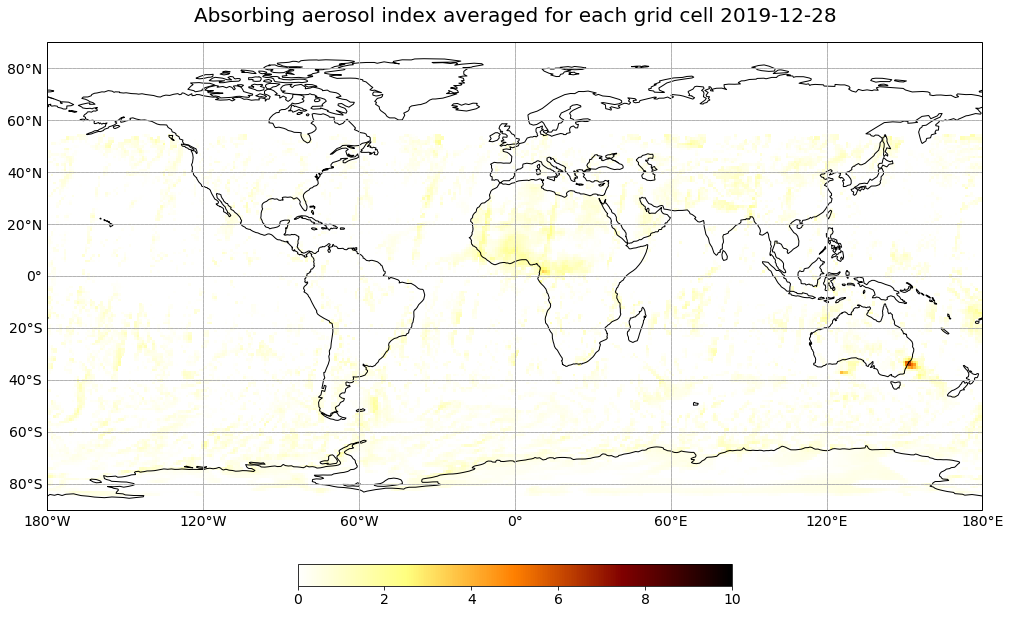

In [13]:
visualize_s5p_pcolormesh(aai_combined[0,:,:],aai_combined.longitude, aai_combined.latitude,
                         ccrs.PlateCarree(), 
                        'afmhot_r', 
                         ' ',
                         aai_a.long_name + ' ' + str(aai_combined.time[0].dt.strftime('%Y-%m-%d').data), 
                         0, 10, 
                         -180, 179.9, -90. , 90., 
                         log=False,
                         set_global=True)


## <a id='animate'></a>Animate daily GOME-2 Level 3 Absorbed Aerosol Index (AAI) data between 28 December 2019 and 20 January 2020

The final step is now to animate the `aai_combined` DataArray over the 24 days to see the dispersion of Aerosols resulting from biomass burning during the severe Australian Fires in January 2020.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [14]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_s5p_pcolormesh(aai_combined[0,:,:],aai_combined.longitude, aai_combined.latitude,ccrs.PlateCarree(), 
                        'afmhot_r', ' ',aai_a.long_name + '/' + str(aai_combined.time[0].dt.strftime('%Y-%m-%d').data), 0, 10, -180, 180, -90. , 90., log=False,set_global=True)


frames = 24


def draw(i):
    img = plt.pcolormesh(aai_combined.longitude, aai_combined.latitude, aai_combined[i,:,:], 
                        cmap='afmhot_r', transform=ccrs.PlateCarree(),
                        vmin=0,
                        vmax=10)
    ax.set_title(aai_a.long_name + ' ' + str(aai_combined.time[i].dt.strftime('%Y-%m-%d').data),
                fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)


#### Play the animation as HTML5 video

In [15]:
HTML(ani.to_html5_video())

<br>

<a href="./214_ltpy_AC_SAF_GOME-2_L3.ipynb"><< 214 - AC SAF GOME-2 - Level 3</a><span style="float:right;"><a href="./22_ltpy_GOME-2_PMAp_load_browse.ipynb">22 - GOME-2 - PMAp product - Load and browse >></a></span>

<hr>

<p><img src='./img/copernicius_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>